# Introdução às Redes Neurais Fisicamente Informadas - PINNs (Dia 06) Picture1.jpg

---
### Exemplo 9

**Objetivo:** Neste notebook vamos resolver o problema do escoamento em cavidade com tampa móvel estacionário. Para tal consideramos as equações de Navier-Stokes $$\mathbf{u}\cdot\nabla \mathbf{u}=-\nabla p + \frac{1}{Re}\Delta \mathbf{u}$$
e a equação da continuidade $$\nabla \cdot \mathbf{u}=0,$$ sendo $Re=100$, $\mathbf{u}=(u,v)$ o vetor de velocidade e $p$ a pressão. O domínio considerado é o quadrado $[0,1]^2$ e as condições de contorno são:
* Dirichlet $u(0,y)=u(x,0)=u(1,y)=v(0,y)=v(x,0)=v(1,y)=v(x,1)=0;$
* Dirichlet $u(x,1)=1$;
* Pressão $p(0,0)=0$.

*Referência: *Ghia, Ghia, Shin. High-Re solutions for incompressible flow using the Navier-Stokes equations and a multigrid method, Journal of Computational Physics, Vol. 48, 387-411, 1982.*



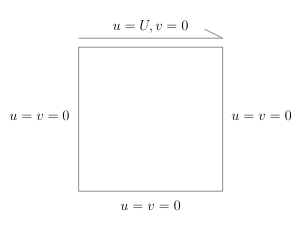

---
Instalando o DeepXDE

In [ ]:
# carrega o deepxde
!pip install deepxde -q gwpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.7/183.7 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 6.4 MB/s eta 0:00:00


---
Importa as coisas necessárias

*Obs.: aqui estou trocando o backend para o pytorch, pois o L-BFGS não está funcionando no backend Tensorflow (nem o v1 e nem o v2). É possível usar o backend PaddlePaddle, que é o recomendado pela equipe do DeepXDE. Caso queira utilizar o PaddlePaddle é necessário fazer a instalação utilizando o comando `!pip install paddlepaddle-gpu==2.6.0.post120 -f https://www.paddlepaddle.org.cn/whl/linux/mkl/avx/stable.html`. A GPU do Google Colab está com o CUDA na versão 12.2, por isso, deve-se instalar a versão para GPU com CUDA 12.0 do PaddlePaddle. Caso a NVIDIA mude a versão do CUDA, o parâmetro `post120` que aparece no comando de instalação deve ser mudado para a versão mais atual que o PaddlePaddle disponibiliza. Na data de hoje, 17 de agosto de 2024, a versão mais atual do PaddlePaddle é com o parâmetro `post120`.*

In [ ]:
# Troca o backend para o pytorch. Caso queira usar o PaddlePaddle, basta trocar pytorch por paddle (depois de instalá-lo).
import os
os.environ['DDE_BACKEND'] = 'pytorch'

import deepxde as dde

# Troca o tipo de ponto flutuante para 64 bit, originalmente é 32 bit (essa alteração é necessária)
dde.config.set_default_float('float64')

import numpy as np

# Caso precise usar alguma função específica do pytorch (não é o caso deste notebook)
import torch
# Exemplo: caso precise usar um seno, deve-se usar: torch.sin(...)

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


pytorch
Set the default float type to float64


---
**1$^\mathrm{a}$ Etapa**

Define as equações diferenciais do problema da cavidade no plano

N-S estacionária: $\mathbf{u}\cdot\nabla \mathbf{u}=-\nabla p + \frac{1}{Re}\Delta \mathbf{u}$

Continuidade: $\nabla \cdot \mathbf{u}=0$

Temos uma novidade nesta parte que é a combinação de índices nos módulos para o cálculo da primeira e segunda derivada. Essa combinação é explicada a seguir.

Para o módulo `dde.grad.jacobian`:
* os índices `i` e `j` correspondem aos índices, respectivamente, da variável dependente e da variável independente. Assim, supondo que $\mathbf{u}=(u,v,p)$, então, por exemplo,
  * `dde.grad.jacobian(u, x, i=0, j=0)` fornece $\frac{\partial u}{\partial x}$
  * `dde.grad.jacobian(u, x, i=1, j=1)` fornece $\frac{\partial v}{\partial y}$
  * `dde.grad.jacobian(u, x, i=2, j=0)` fornece $\frac{\partial p}{\partial x}$    

Para o módulo `dde.grad.hessian`:
* `component` define a componente que está calculando o Hessiano, caso seja um vetor
* os índices `i` e `j` correspondem aos índices das variáveis que serão calculadas. Assim, se `i=0` corresponde a $x$ e `j=1` a $y$, então:
  * `dde.grad.hessian(u, x, component=0, i=0, j=0)` fornece $\frac{\partial ^2 u}{\partial x^2}$
  * `dde.grad.hessian(u, x, component=0, i=1, j=0)` fornece $\frac{\partial ^2 u}{\partial x\partial y}$
  * `dde.grad.hessian(u, x, component=0, i=0, j=1)` fornece $\frac{\partial ^2 u}{\partial y\partial x}$
  * `dde.grad.hessian(u, x, component=0, i=1, j=1)` fornece $\frac{\partial ^2 u}{\partial y^2}$   

Analogamente, para a segunda componente que representa a variável de velocidade $v$.

In [ ]:
# define as equações do momento + equação da continuidade
# problema em regime permanente
def pde(x, u):
    Re = 100

    u_vel, v_vel, p = u[:, 0:1], u[:, 1:2], u[:, 2:]

    # calcula as derivadas parciais
    u_vel_x = dde.grad.jacobian(u, x, i=0, j=0) # aqui a componente é indicada pelo índice i
    u_vel_y = dde.grad.jacobian(u, x, i=0, j=1)
    u_vel_xx = dde.grad.hessian(u, x, component=0, i=0, j=0)
    u_vel_yy = dde.grad.hessian(u, x, component=0, i=1, j=1) # 'component' só é necessária no módulo do hessiano

    v_vel_x = dde.grad.jacobian(u, x, i=1, j=0)
    v_vel_y = dde.grad.jacobian(u, x, i=1, j=1)
    v_vel_xx = dde.grad.hessian(u, x, component=1, i=0, j=0)
    v_vel_yy = dde.grad.hessian(u, x, component=1, i=1, j=1)

    p_x = dde.grad.jacobian(u, x, i=2, j=0)
    p_y = dde.grad.jacobian(u, x, i=2, j=1)

    # define das funções de perda para cada equação
    momentum_x = (
       ( u_vel * u_vel_x + v_vel * u_vel_y + p_x - (1 / Re) * (u_vel_xx + u_vel_yy) )
    )
    momentum_y = (
       ( u_vel * v_vel_x + v_vel * v_vel_y + p_y - (1 / Re) * (v_vel_xx + v_vel_yy) )
    )
    continuity = ( u_vel_x + v_vel_y )

    return [momentum_x, momentum_y, continuity]

---
**2$^\mathrm{a}$ Etapa**

Definimos as condições de contorno para um quadrado unitário $D=[0,1]\times [0,1]$

BC:
1.   Dirichlet $u(0,y)=u(x,0)=u(1,y)=v(0,y)=v(x,0)=v(1,y)=v(x,1)=0$
2.   Dirichlet $u(x,1)=1$
3.   Pressão $p(0,0)=0$

A novidade aqui é que podemos definir a geometria com o módulo `dde.geometry.Rectangle(VIE, VSD)`

In [ ]:
# constrói a geometria: R=[0,1]^2
geom = dde.geometry.Rectangle([0, 0], [1, 1])

# define as quatro fronteiras do quadrado
def boundary_left(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], 0.0)

def boundary_right(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], 1.0)

def boundary_top(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[1], 1.0)

def boundary_bottom(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[1], 0.0)

# condições de contorno de dirichlet nas velocidades
# condições de não-deslizamento
u_t_bc = dde.icbc.DirichletBC(geom, lambda x: 1, boundary_top, component=0)
u_r_bc = dde.icbc.DirichletBC(geom, lambda x: 0, boundary_right, component=0)
u_l_bc = dde.icbc.DirichletBC(geom, lambda x: 0, boundary_left, component=0)
u_b_bc = dde.icbc.DirichletBC(geom, lambda x: 0, boundary_bottom, component=0)

v_t_bc = dde.icbc.DirichletBC(geom, lambda x: 0, boundary_top, component=1)
v_r_bc = dde.icbc.DirichletBC(geom, lambda x: 0, boundary_right, component=1)
v_l_bc = dde.icbc.DirichletBC(geom, lambda x: 0, boundary_left, component=1)
v_b_bc = dde.icbc.DirichletBC(geom, lambda x: 0, boundary_bottom, component=1)

# condições de contorno para a pressão
p_o_bc = dde.icbc.PointSetBC([[0,0]], [0], component=2)

# compila as condições de contorno do problema
bc = [u_t_bc, u_r_bc, u_l_bc, u_b_bc, v_t_bc, v_r_bc, v_l_bc, v_b_bc, p_o_bc]

---
**3$^\mathrm{a}$ Etapa**

Cria e compila a rede neural.

Aqui vamos fazer um treinamento usando dois otimizadores diferente: `ADAM` e `L-BFGS`. A ideia de fazer o treinamento em duas etapas é calcular os parâmetros treináveis de forma mais rápida utilizando o `ADAM` e, em seguida, utilizar o `L-BFGS` para melhorar a precisão.

Um outro detalhe é que está sendo utilizado a cada época um reamostrador dos dados de treinamento a cada 100 iterações. Isso é feito usando o comando `PDEPointResampler(...)`. Essa estratégia ajuda na precisão.

*Referência: L. Lu, X. Meng, Z. Mao, G. Karniadakis. DeepXDE: A deep learning library for solving differential equations, SIAM Review, 63, 1, 208-228, 2021.*

Compiling model...
'compile' took 3.458107 s

Training model...

Step      Train loss                                                                                                                  Test loss                                                                                                                   Test metric
0         [6.29e-04, 3.67e-04, 9.42e-02, 1.03e+00, 1.95e-02, 2.26e-03, 1.01e-02, 4.04e-03, 9.01e-03, 5.87e-03, 8.29e-03, 0.00e+00]    [5.74e-04, 3.21e-04, 9.50e-02, 1.03e+00, 1.95e-02, 2.26e-03, 1.01e-02, 4.04e-03, 9.01e-03, 5.87e-03, 8.29e-03, 0.00e+00]    []  
1000      [4.08e-03, 1.60e-03, 4.29e-03, 2.85e-02, 4.06e-02, 4.73e-02, 9.01e-04, 2.72e-03, 4.46e-04, 1.73e-03, 2.17e-04, 5.31e-07]    [3.23e-03, 1.44e-03, 2.94e-03, 2.85e-02, 4.06e-02, 4.73e-02, 9.01e-04, 2.72e-03, 4.46e-04, 1.73e-03, 2.17e-04, 5.31e-07]    []  

Best model at step 1000:
  train loss: 1.32e-01
  test loss: 1.30e-01
  test metric: []

'train' took 68.190111 s

Compiling model...
'com

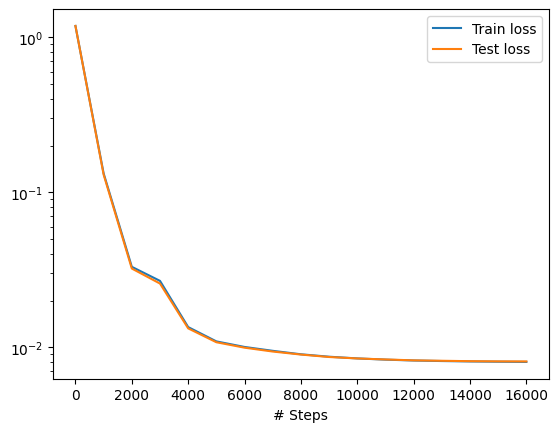

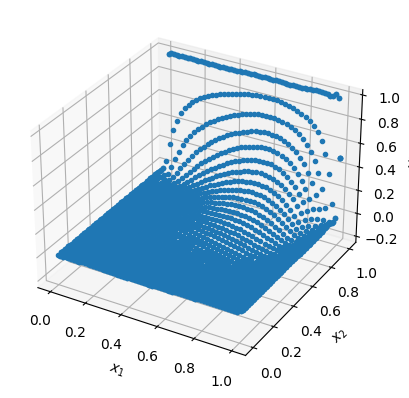

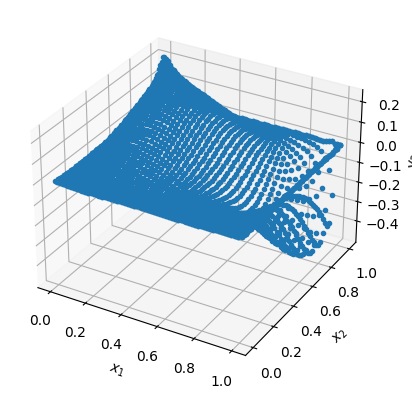

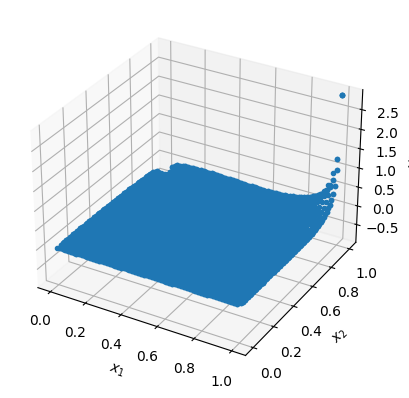

In [ ]:
# construção do modelo
data = dde.data.PDE(
    geom,
    pde,
    bc,
    num_domain=1800,
    num_boundary=250,
    num_test=1800,
)

net = dde.nn.FNN([2] + 4 * [125] + [3], "tanh", "Glorot normal")

model = dde.Model(data, net)

# compila o modelo: primeiro adam e depois l-bfgs para melhorar a precisão
model.compile("adam", lr=1e-4)

resampler = dde.callbacks.PDEPointResampler(period=100)
model.train(iterations=30000, callbacks=[resampler])

dde.optimizers.set_LBFGS_options()
model.compile("L-BFGS")
losshistory, train_state = model.train(callbacks=[resampler])
dde.saveplot(losshistory, train_state, issave=False, isplot=True)

---
**4$^\mathrm{a}$ Etapa**

Imprime a solução no plano $x-y$.

Estamos aqui comparando a solução encontrada com a solução clássica do trabalho: *Ghia, Ghia, Shin. High-Re solutions for incompressible flow using the Navier-Stokes equations and a multigrid method, Journal of Computational Physics, Vol. 48, 387-411, 1982.*


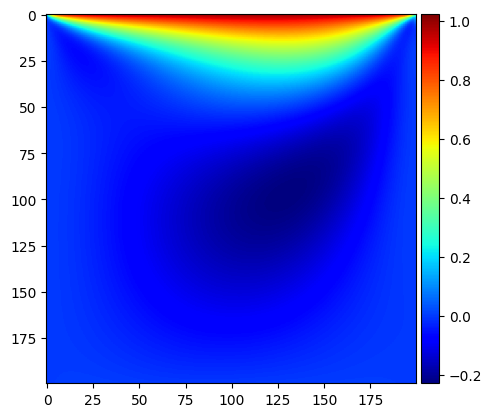

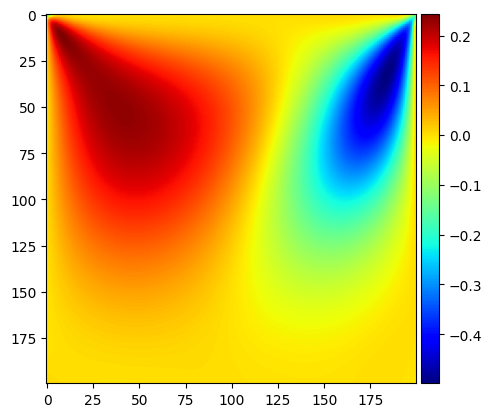

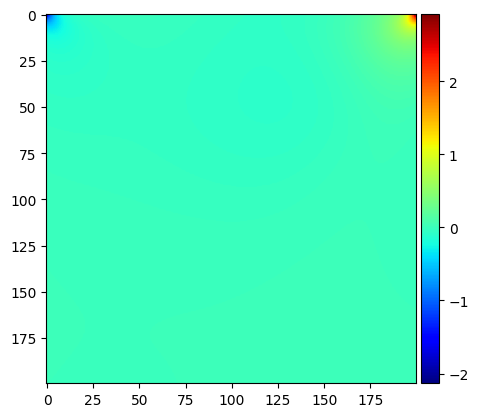

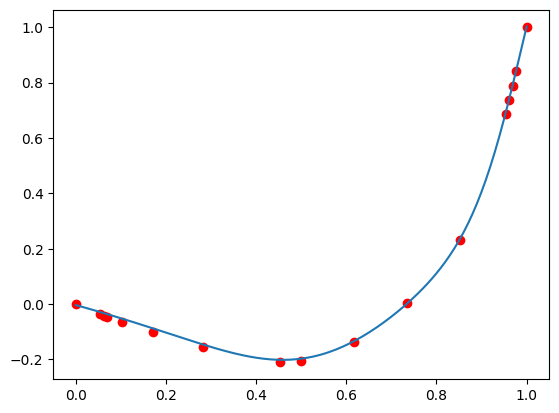

In [ ]:
# imprime a solução como um mapa de calor
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

nop = 200

Nx = nop
Ny = nop

# monta o grid
xmin, xmax, ymin, ymax = [0, 1, 0, 1]
plot_grid = np.mgrid[xmin : xmax : Nx * 1j, ymin : ymax : Ny * 1j]
points = np.vstack(
    (plot_grid[0].ravel(), plot_grid[1].ravel(), np.zeros(plot_grid[0].size))
)

# aplica os pontos do grid no modelo
W = model.predict(points[:2, :].T)
u = W[:, 0:1].reshape((Nx, Ny))
v = W[:, 1:2].reshape((Nx, Ny))
p = W[:, 2:].reshape((Nx, Ny))

matrix_U = np.fliplr(u).T
matrix_V = np.fliplr(v).T
matrix_p = np.fliplr(p).T

# imprime o bicho
fig, (ax1) = plt.subplots(1, 1)
im1 = ax1.imshow(matrix_U, cmap='jet')

divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im1, cax=cax1)

fig, (ax2) = plt.subplots(1, 1)
im2 = ax2.imshow(matrix_V, cmap='jet')
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im2, cax=cax2)

fig, (ax3) = plt.subplots(1, 1)
im3 = ax3.imshow(matrix_p, cmap='jet')
divider3 = make_axes_locatable(ax3)
cax3 = divider3.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im3, cax=cax3)

fig, (ax4) = plt.subplots(1,1)
ref_x = [1.0000, 0.9766, 0.9688, 0.9609, 0.9531, 0.8516, 0.7344, 0.6172, 0.5000, 0.4531, 0.2813, 0.1719, 0.1016, 0.0703, 0.0625, 0.0547, 0.0000]
ref_u = [1.00000, 0.84123, 0.78871, 0.73722, 0.68717, 0.23151, 0.00332, -0.13641, -0.20581, -0.21090, -0.15662, -0.10150, -0.06434, -0.04775, -0.04192, -0.03717, 0.00000]

ax4.plot(ref_x, ref_u, 'ro', plot_grid[1,int(nop/2),:],u[int(nop/2),:])
plt.show()